In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import ward, complete, average, single
from sklearn.metrics import pairwise_distances
import time
import sys
import warnings
warnings.filterwarnings('ignore')

In [22]:
iris_data = pd.read_csv('iris.data', header=None)
iris_labels = iris_data.iloc[:, -1]
iris_data = iris_data.drop(columns=iris_data.columns[-1])

print("Iris Dataset Description:")
print(f"Shape: {iris_data.shape}")
print(f"Number of features: {iris_data.shape[1]}")

distinct_labels = iris_labels.unique()
print(f"Distinct labels: {len(distinct_labels)}")
print(f"Instances per label: {iris_labels.value_counts().to_dict()}")

Iris Dataset Description:
Shape: (150, 4)
Number of features: 4
Distinct labels: 3
Instances per label: {'Iris-setosa': 50, 'Iris-versicolor': 50, 'Iris-virginica': 50}


In [23]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist_data = mnist.data
mnist_labels = mnist.target.astype(int)

mnist_subset_data, _, mnist_subset_labels, _ = train_test_split(
    mnist_data, mnist_labels,
    stratify=mnist_labels,
    test_size=0.95,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    mnist_subset_data, mnist_subset_labels,
    test_size=0.3,
    stratify=mnist_subset_labels,
    random_state=42
)

print("\nMNIST Subset Description:")
print(f"Shape: {mnist_subset_data.shape}")
print(f"Number of features: {mnist_subset_data.shape[1]}")
print(f"Distinct labels: {len(np.unique(mnist_subset_labels))}")

mnist_subset_labels_series = pd.Series(mnist_subset_labels)
print(f"Instances per label: {mnist_subset_labels_series.value_counts().to_dict()}")

print("\nMNIST Train Split Description:")
print(f"Train Shape: {X_train.shape}")
print(f"Train Instances per label: {pd.Series(y_train).value_counts().to_dict()}")

print("\nMNIST Test Split Description:")
print(f"Test Shape: {X_test.shape}")
print(f"Test Instances per label: {pd.Series(y_test).value_counts().to_dict()}")



MNIST Subset Description:
Shape: (3500, 784)
Number of features: 784
Distinct labels: 10
Instances per label: {1: 394, 7: 365, 3: 357, 2: 349, 9: 348, 0: 345, 6: 344, 4: 341, 8: 341, 5: 316}

MNIST Train Split Description:
Train Shape: (2450, 784)
Train Instances per label: {1: 276, 7: 255, 3: 250, 9: 244, 2: 244, 6: 241, 0: 241, 4: 239, 8: 239, 5: 221}

MNIST Test Split Description:
Test Shape: (1050, 784)
Test Instances per label: {1: 118, 7: 110, 3: 107, 2: 105, 0: 104, 9: 104, 6: 103, 4: 102, 8: 102, 5: 95}


In [24]:
def elbow_method(data, range_k, dataset_name, true_labels=None):
    sse = []
    running_times = []

    for k in range_k:
        start_time = time.time()
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        end_time = time.time()

        sse.append(kmeans.inertia_)
        running_times.append(end_time - start_time)

    plt.figure(figsize=(10, 6))
    plt.plot(range_k, sse, marker='o', label='SSE')
    plt.title(f'Elbow Method for {dataset_name} Dataset')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.xticks(range_k)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"elbow_method_{dataset_name}_SSE.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range_k, running_times, marker='o', color='red', label='Running Time')
    plt.title(f'Running Time Analysis for {dataset_name} Dataset')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Running Time (seconds)')
    plt.xticks(range_k)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"elbow_method_{dataset_name}_RunningTime.png")
    plt.show()

    if true_labels is not None:
        aris = []
        for k in range_k:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(data)
            ari = adjusted_rand_score(true_labels, kmeans.labels_)
            aris.append(ari)

        plt.figure(figsize=(10, 6))
        plt.plot(range_k, aris, marker='o', color='green', label='ARI')
        plt.title(f'Adjusted Rand Index for {dataset_name} Dataset')
        plt.xlabel('Number of clusters (K)')
        plt.ylabel('ARI')
        plt.xticks(range_k)
        plt.legend()
        plt.grid(True)
        plt.savefig(f"elbow_method_{dataset_name}_ARI.png")
        plt.show()

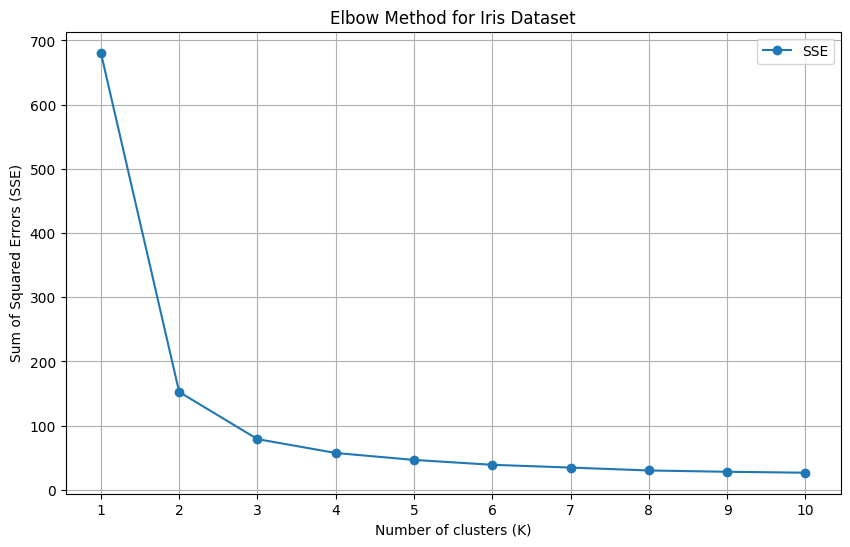

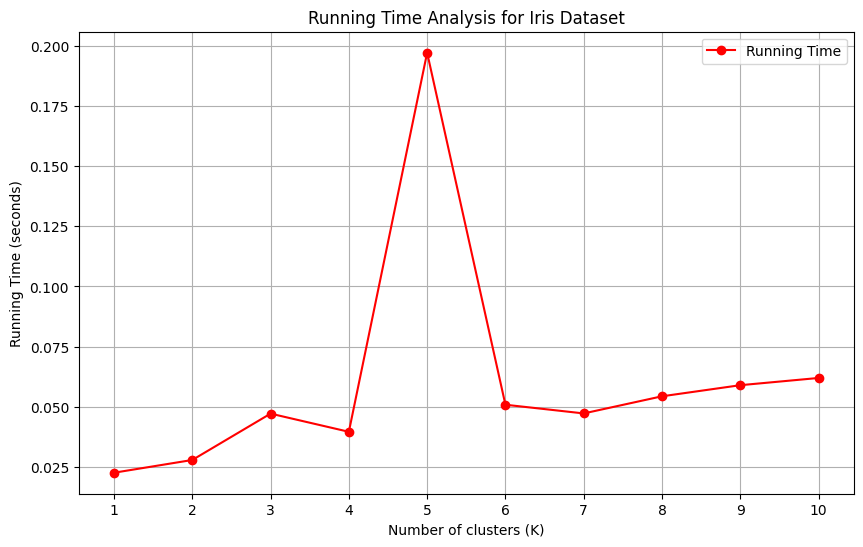

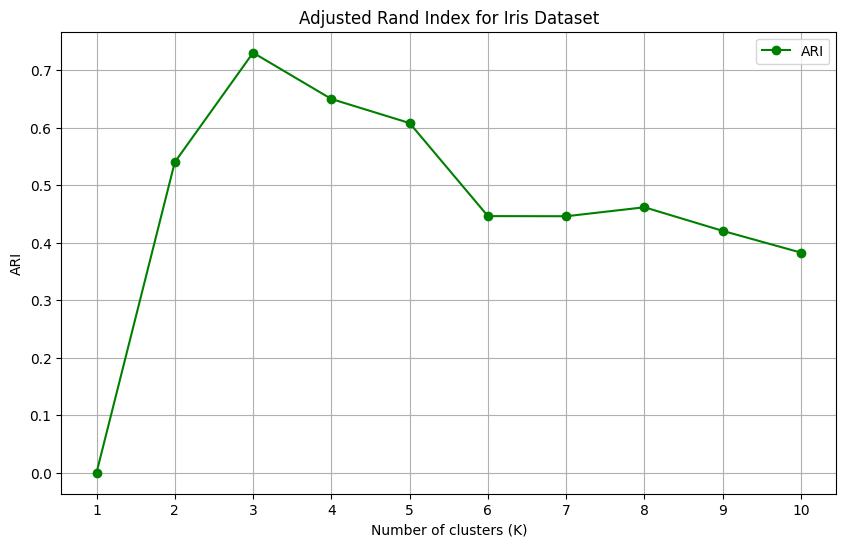

In [25]:
elbow_method(iris_data, range(1, 11), "Iris", iris_labels)

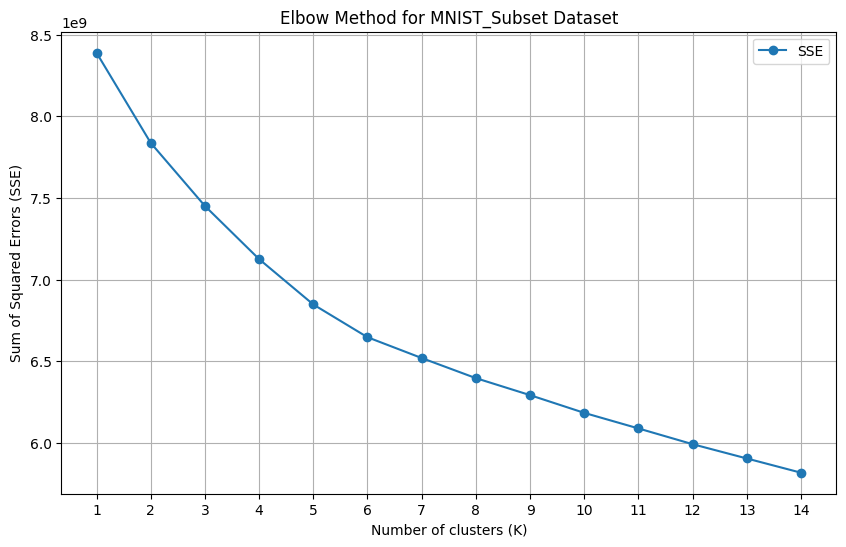

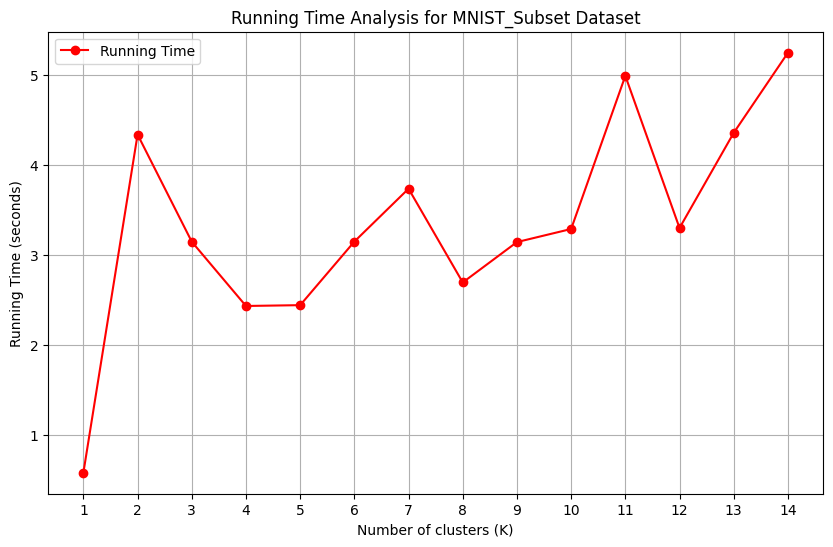

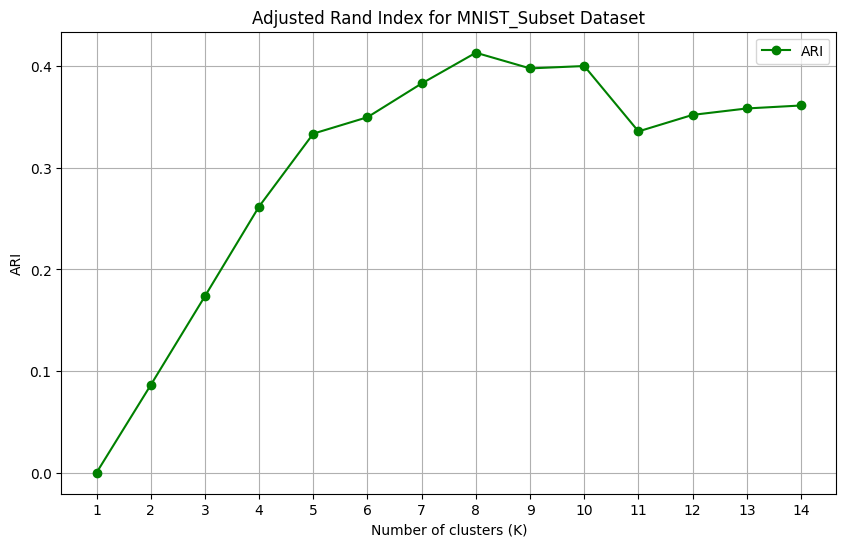

In [26]:
elbow_method(X_train, range(1, 15), "MNIST_Subset", y_train)

In [27]:
#elbow_method(X_train, range(1, 15), "MNIST_Subset")

In [28]:
def elbow_method_metrics(data, range_k, dataset_name, true_labels=None):
    metrics = {'K': [], 'SSE': [], 'Running Time': []}
    if true_labels is not None:
        metrics['ARI'] = []

    for k in range_k:
        start_time = time.time()
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        end_time = time.time()

        metrics['K'].append(k)
        metrics['SSE'].append(kmeans.inertia_)
        metrics['Running Time'].append(end_time - start_time)

        if true_labels is not None:
            ari = adjusted_rand_score(true_labels, kmeans.labels_)
            metrics['ARI'].append(ari)

    return pd.DataFrame(metrics)

iris_metrics = elbow_method_metrics(iris_data, range(1, 11), "Iris", iris_labels)
mnist_metrics = elbow_method_metrics(X_train, range(1, 15), "MNIST_Subset", y_train)

In [29]:
print("Iris Dataset Metrics:")
print(iris_metrics)

Iris Dataset Metrics:
    K         SSE  Running Time       ARI
0   1  680.824400      0.027212  0.000000
1   2  152.368706      0.021516  0.539922
2   3   78.940841      0.014574  0.730238
3   4   57.317873      0.027143  0.649818
4   5   46.535582      0.037614  0.607896
5   6   38.930963      0.038547  0.446168
6   7   34.598978      0.042066  0.445948
7   8   30.085308      0.055423  0.461531
8   9   28.063275      0.053545  0.420480
9  10   26.587317      0.114796  0.382652


In [30]:
print("\nMNIST Subset Dataset Metrics:")
print(mnist_metrics)


MNIST Subset Dataset Metrics:
     K           SSE  Running Time       ARI
0    1  8.388694e+09      0.501774  0.000000
1    2  7.837041e+09      3.610741  0.086210
2    3  7.451064e+09      2.230880  0.173630
3    4  7.125735e+09      3.513902  0.261956
4    5  6.848187e+09      2.844472  0.333658
5    6  6.647714e+09      4.458985  0.349834
6    7  6.520401e+09      3.554189  0.383036
7    8  6.397374e+09      5.414258  0.413284
8    9  6.293361e+09      4.870601  0.397862
9   10  6.184787e+09      6.674543  0.400205
10  11  6.089546e+09      4.109621  0.335857
11  12  5.993164e+09      3.356015  0.352126
12  13  5.905745e+09      7.784225  0.358441
13  14  5.818619e+09      9.333850  0.361362


In [31]:
sys.setrecursionlimit(10000)

def hierarchical_clustering_scipy(data, labels, methods):
    results = []
    for method in methods:
        start_time = time.time()
        linked = linkage(data, method=method)
        cluster_labels = fcluster(linked, t=3, criterion='maxclust')
        end_time = time.time()
        ari = adjusted_rand_score(labels, cluster_labels)
        sse = 0
        for cluster in np.unique(cluster_labels):
            cluster_points = data[cluster_labels == cluster]
            centroid = np.mean(cluster_points, axis=0)
            sse += np.sum((cluster_points - centroid) ** 2)

        results.append({'method': method, 'ARI': ari, 'SSE': sse, 'time': end_time - start_time})

        plt.figure(figsize=(10, 7))
        dendrogram(linked, labels=cluster_labels, no_labels=True)
        plt.title(f"Dendrogram for {method} linkage")
        plt.savefig(f"dendrogram_{method}.png")
        plt.show()

    return pd.DataFrame(results)

linkage_methods = ['ward', 'complete', 'average', 'single']

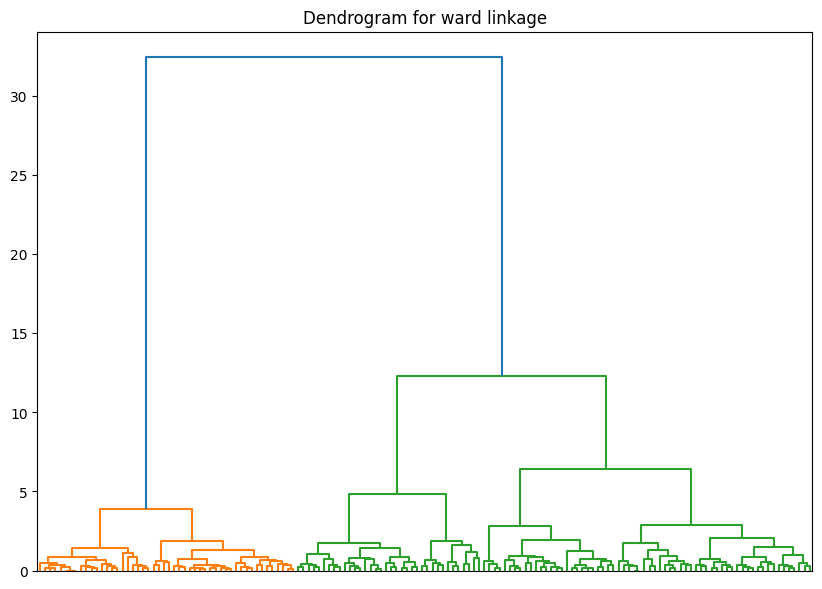

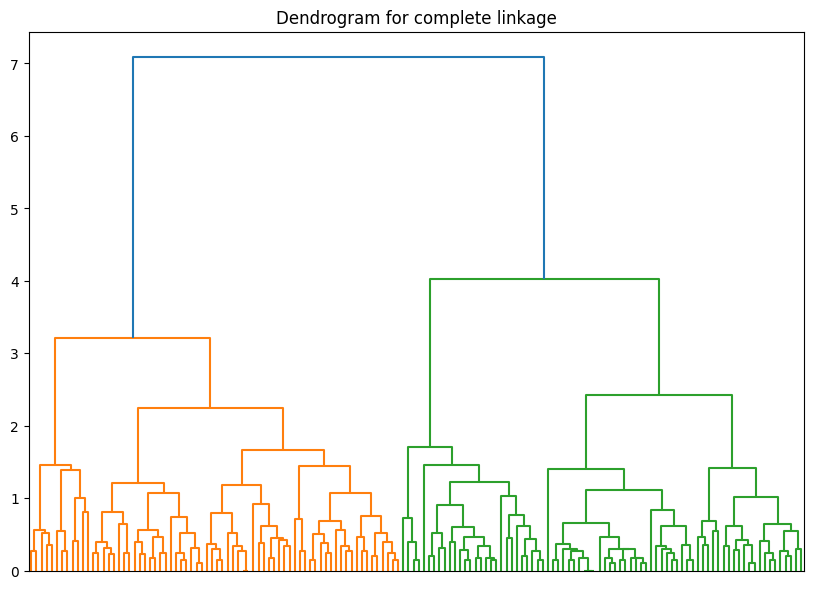

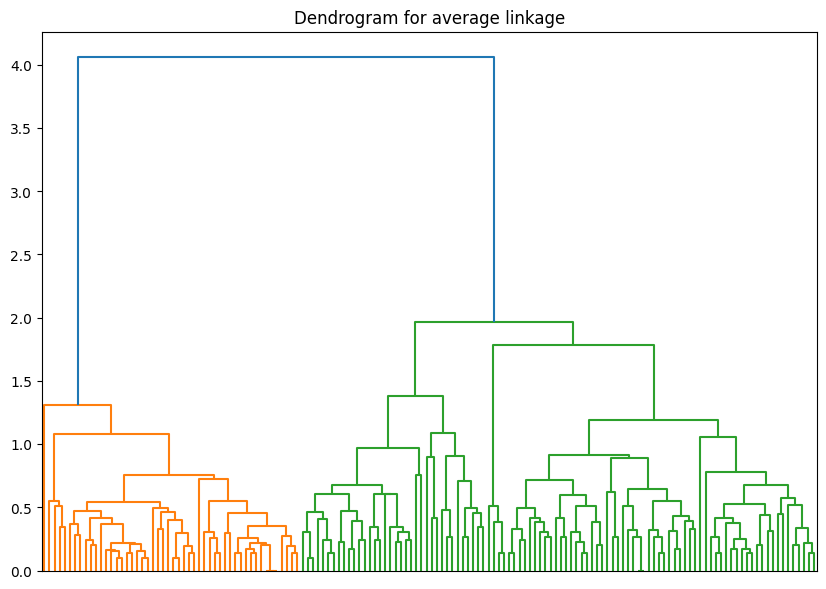

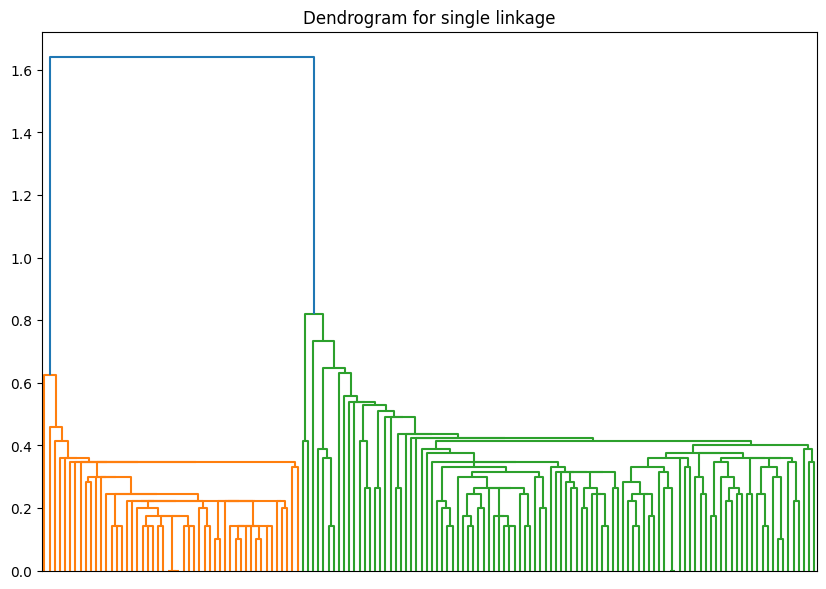

In [39]:
iris_results = hierarchical_clustering_scipy(iris_data.to_numpy(), iris_labels, linkage_methods)

In [40]:
print("Hierarchical Clustering Analysis for Iris Dataset:")
print(iris_results)

Hierarchical Clustering Analysis for Iris Dataset:
     method       ARI         SSE      time
0      ward  0.731199   79.386528  0.001704
1  complete  0.642251   89.614408  0.001802
2   average  0.759199   79.534775  0.001570
3    single  0.563751  142.568767  0.001252


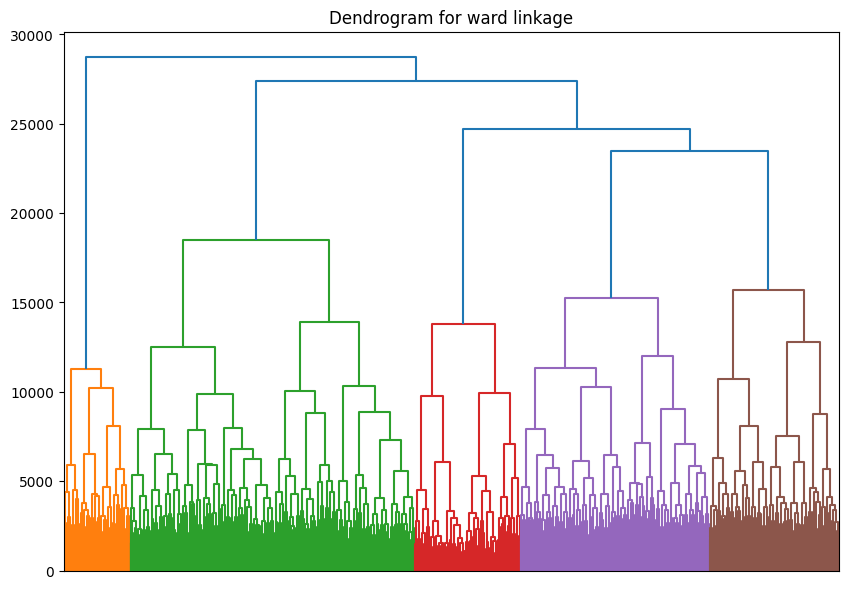

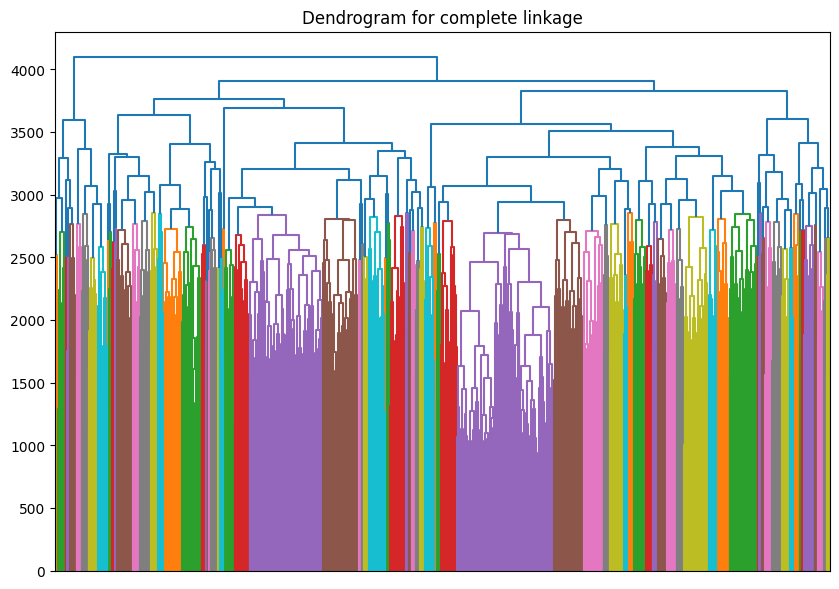

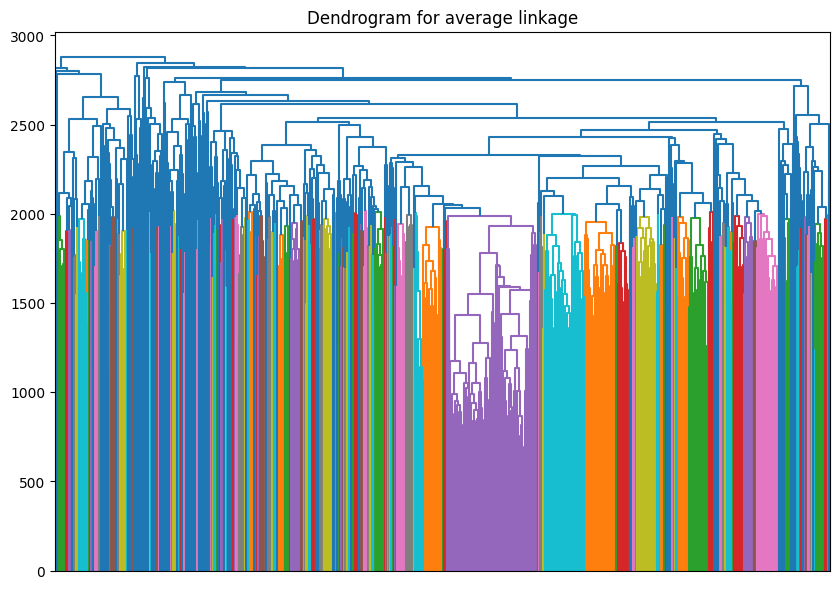

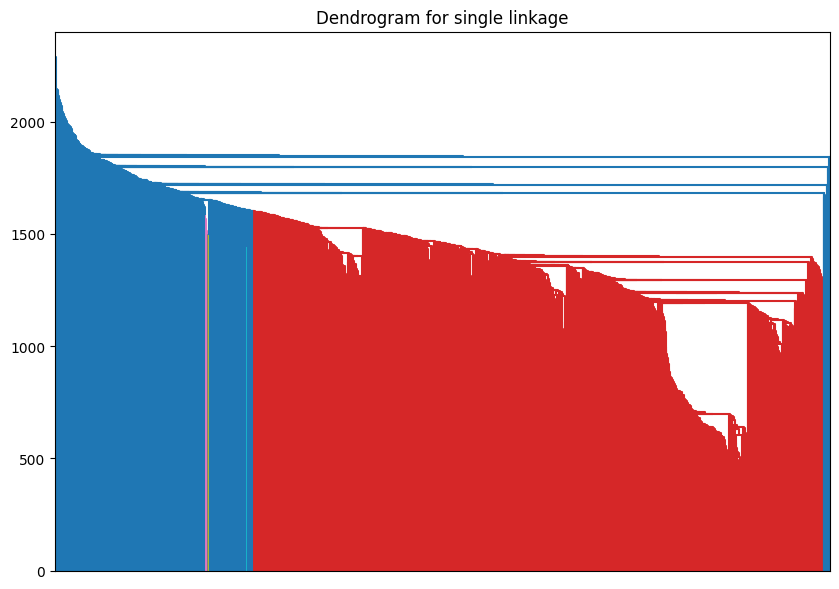

In [41]:
mnist_results = hierarchical_clustering_scipy(X_train, y_train, linkage_methods)

In [42]:
print("Hierarchical Clustering Analysis for MNIST Subset:")
print(mnist_results)

Hierarchical Clustering Analysis for MNIST Subset:
     method       ARI           SSE      time
0      ward  0.186167  7.601583e+09  2.676822
1  complete  0.087211  7.756637e+09  1.468988
2   average  0.044496  7.916612e+09  1.419855
3    single  0.000002  8.374857e+09  1.322470


In [37]:
def hierarchical_clustering_sklearn(data, labels, methods):
    results = []

    for method in methods:
        start_time = time.time()
        clustering = AgglomerativeClustering(n_clusters=3, linkage=method)
        clustering.fit(data)
        end_time = time.time()
        ari = adjusted_rand_score(labels, clustering.labels_)

        sse = 0
        cluster_centers = []
        for cluster_id in np.unique(clustering.labels_):
            cluster_points = data[clustering.labels_ == cluster_id]
            cluster_center = np.mean(cluster_points, axis=0)
            cluster_centers.append(cluster_center)
            sse += np.sum((cluster_points - cluster_center) ** 2)

        results.append({'Method': method, 'ARI': ari, 'SSE': sse, 'Time': end_time - start_time})

        linkage_matrix = None
        if method == 'ward':
            linkage_matrix = ward(data)
        elif method == 'complete':
            linkage_matrix = complete(data)
        elif method == 'average':
            linkage_matrix = average(data)
        elif method == 'single':
            linkage_matrix = single(data)

        if linkage_matrix is not None:
            plt.figure(figsize=(10, 7))
            dendrogram(linkage_matrix)
            plt.title(f'Dendrogram for {method} linkage')
            plt.xlabel('Samples')
            plt.ylabel('Distance')
            plt.show()

    return pd.DataFrame(results)

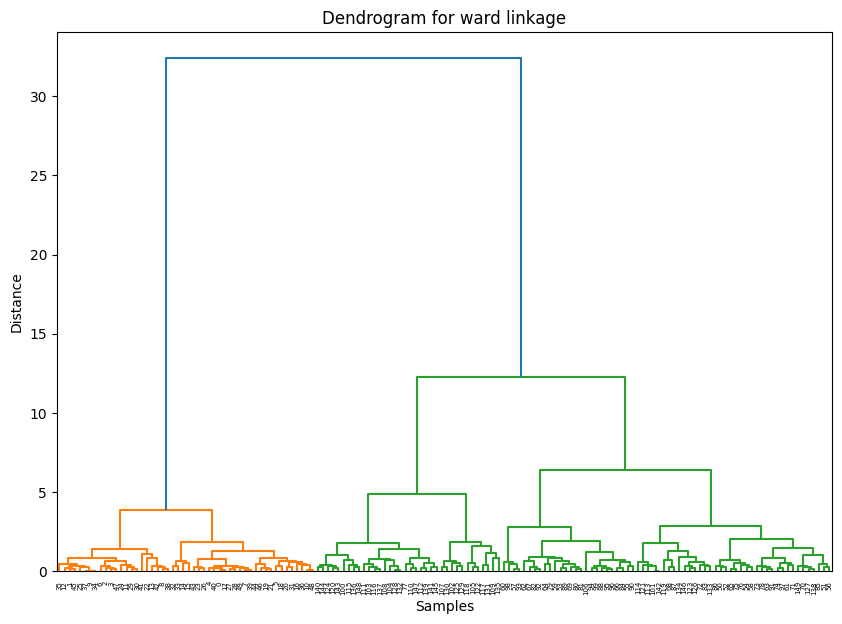

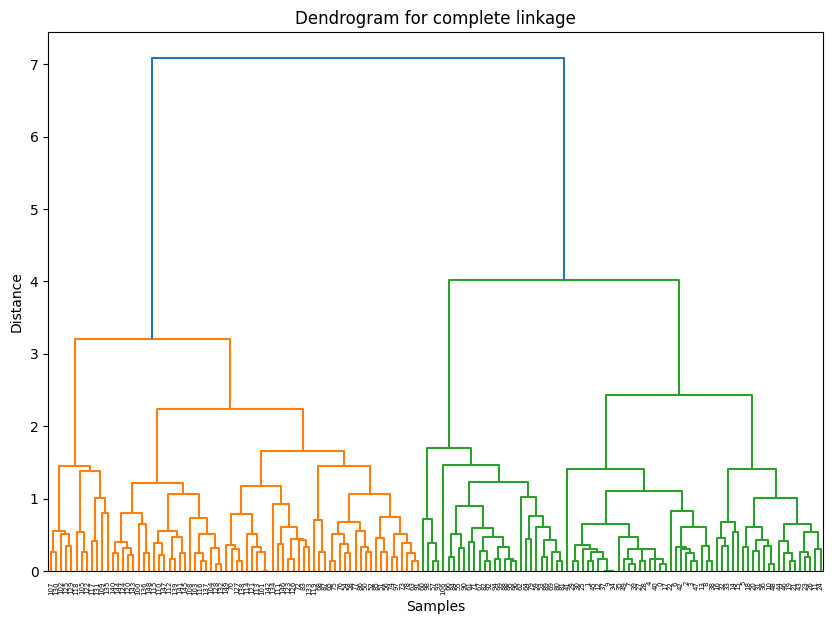

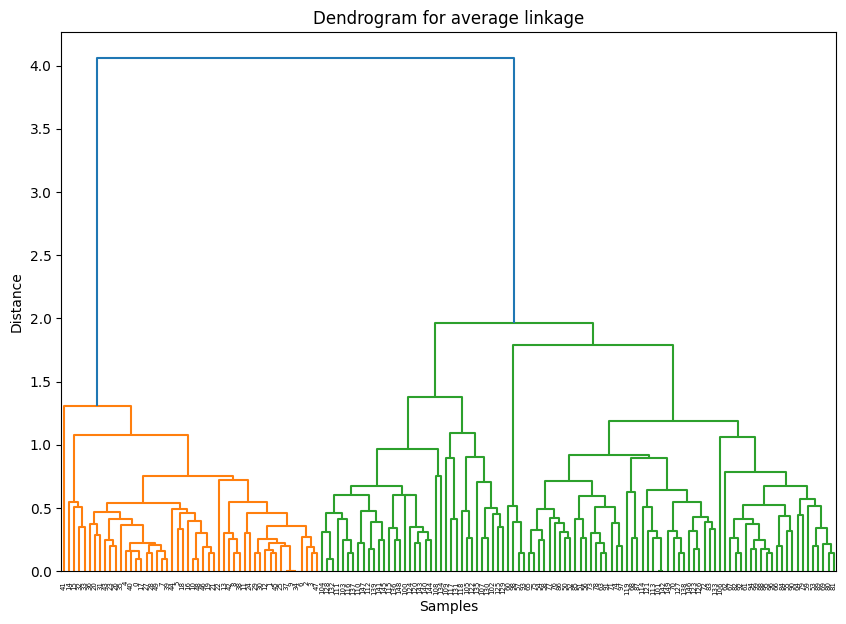

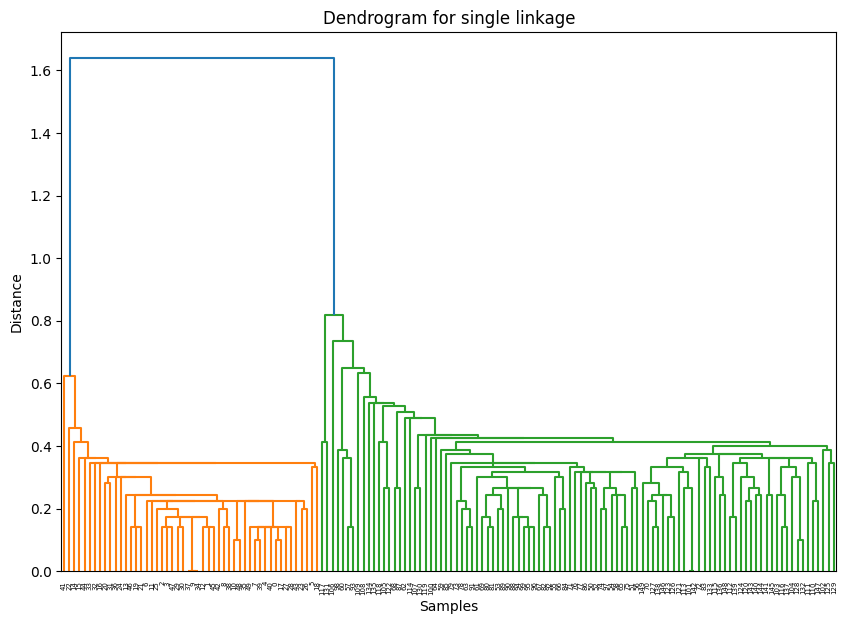

In [43]:
iris_results = hierarchical_clustering_sklearn(iris_data.to_numpy(), iris_labels, ['ward', 'complete', 'average', 'single'])

In [44]:
print("Hierarchical Clustering Analysis for Iris Dataset:")
print(iris_results)

Hierarchical Clustering Analysis for Iris Dataset:
     Method       ARI         SSE      Time
0      ward  0.731199   79.386528  0.004840
1  complete  0.642251   89.614408  0.002552
2   average  0.759199   79.534775  0.002046
3    single  0.563751  142.568767  0.001797


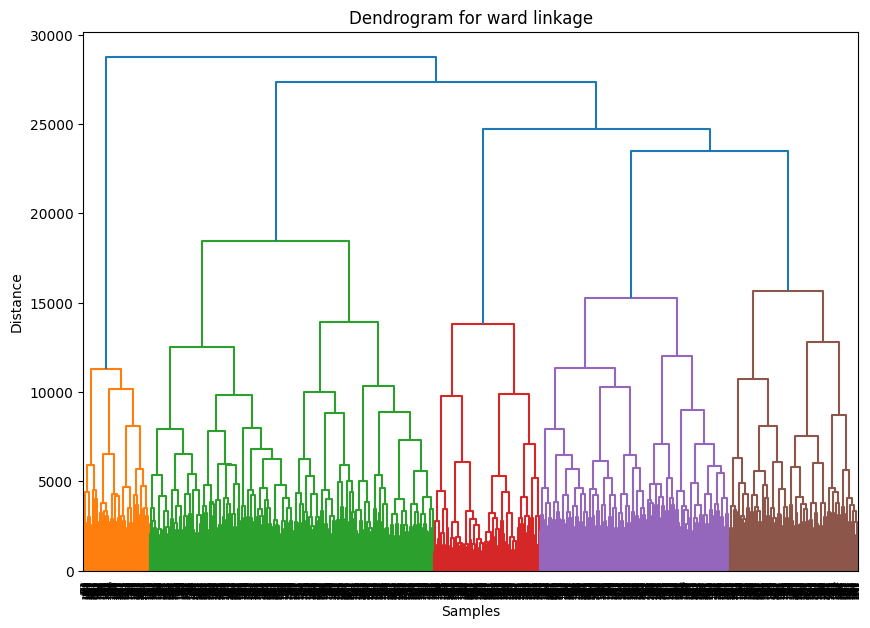

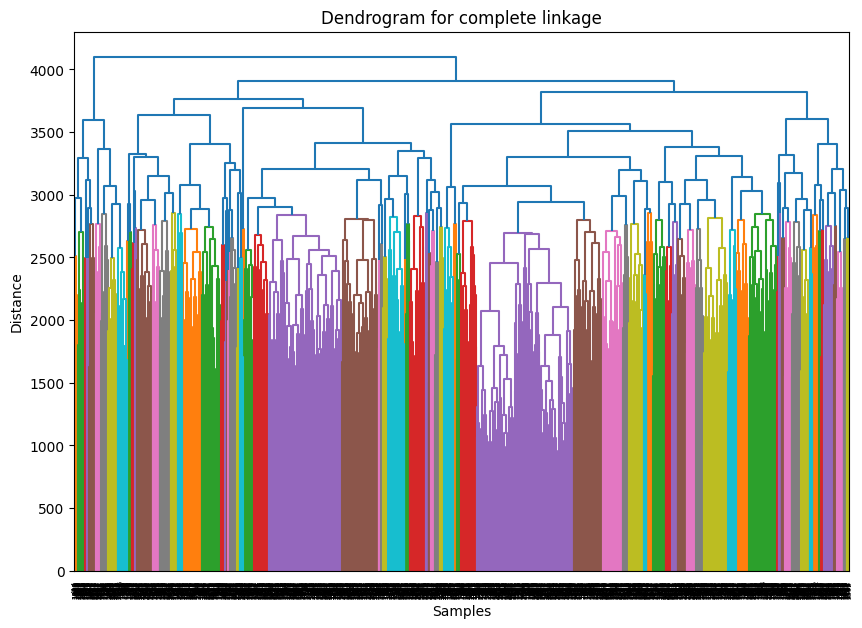

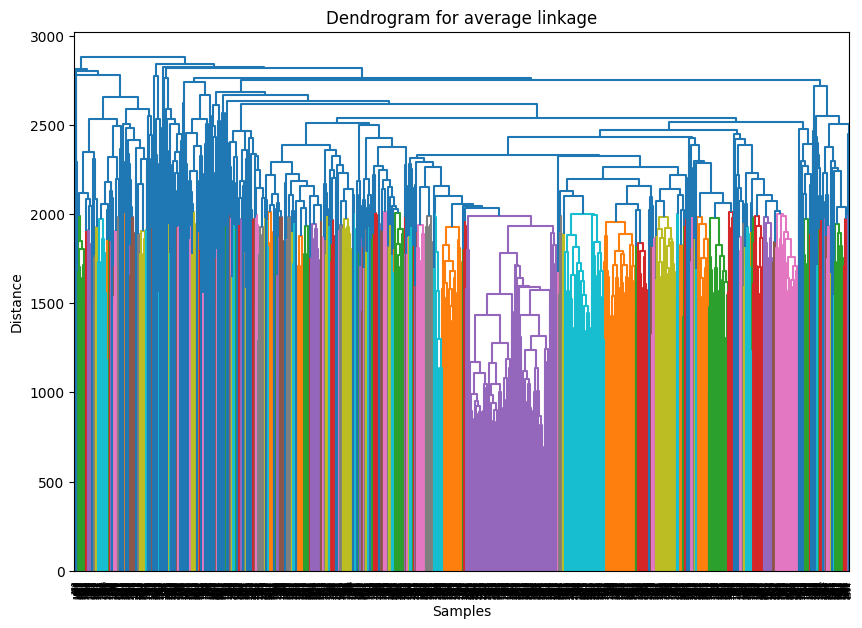

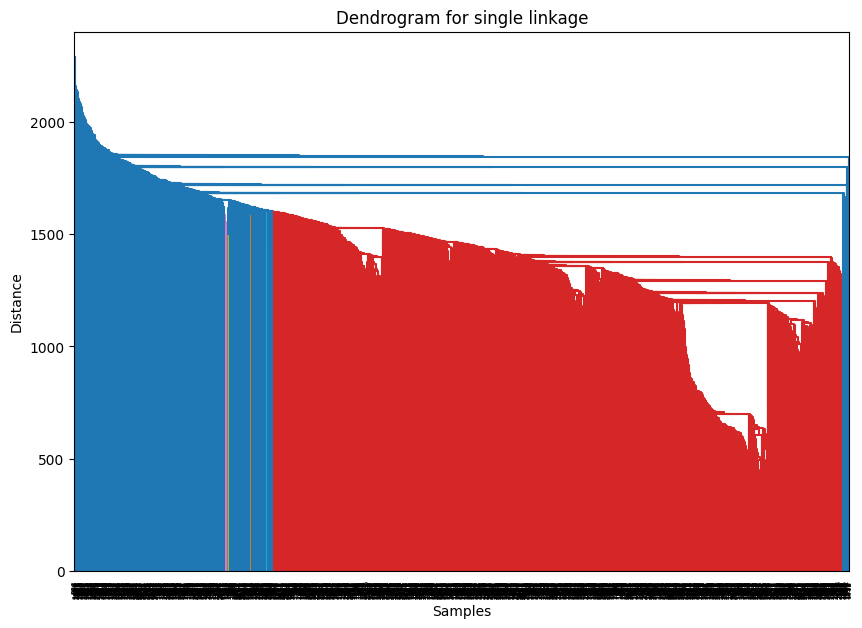

In [45]:
mnist_results = hierarchical_clustering_sklearn(X_train, y_train, ['ward', 'complete', 'average', 'single'])

In [46]:
print("Hierarchical Clustering Analysis for MNIST Subset Dataset:")
print(mnist_results)

Hierarchical Clustering Analysis for MNIST Subset Dataset:
     Method       ARI           SSE      Time
0      ward  0.186167  7.601583e+09  1.412301
1  complete  0.087211  7.756637e+09  2.147065
2   average  0.044496  7.916612e+09  1.454713
3    single  0.000002  8.374857e+09  4.365470
